# Supervised Learning: RQ3-RQ6

## Research Questions
- **RQ3**: Predict major success from admissions + Year 1 data
- **RQ4**: Predict major failure/change from admissions + Year 1 data
- **RQ5**: Predict major success from admissions + Year 1-2 data
- **RQ6**: Predict major failure/change from admissions + Year 1-2 data

## Key Question: Does adding more academic data improve predictions?

In [21]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and move up if so
if current_dir.endswith("notebooks"):
    os.chdir("..") # Move up one level to project root
    sys.path.append(os.getcwd()) # Add project root to python path

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude


In [22]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, fbeta_score, confusion_matrix)

try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False

plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT = Path.cwd()
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results'

In [23]:
# Load data
full_features = pd.read_csv(PROCESSED_DIR / 'full_features.csv')
print(f"Loaded {len(full_features)} students")

# Load master data to get year group for temporal split
master_data = pd.read_csv(PROCESSED_DIR / 'master_student_data.csv')

# Get year group column
yeargroup_col = None
for col in ['Yeargroup', 'yeargroup', 'Year Group']:
    if col in master_data.columns:
        yeargroup_col = col
        break

if yeargroup_col:
    # Merge yeargroup into full_features
    yeargroup_map = master_data.set_index('student_id')[yeargroup_col].to_dict()
    full_features['yeargroup'] = full_features['student_id'].map(yeargroup_map)
    print(f"\nYear group distribution:")
    print(full_features['yeargroup'].value_counts().sort_index())
else:
    print("Warning: No yeargroup column found - will use random split")

Loaded 3718 students

Year group distribution:
yeargroup
2009      1
2011      1
2013      1
2014      5
2015     19
2016    155
2017    158
2018    142
2019    174
2020    257
2021    280
2022    323
2023    337
2024    347
2025    342
2026    374
2027    396
2028    406
Name: count, dtype: int64


In [24]:
# Define feature sets

# Admissions features
admissions_features = [
    'gender_male', 'is_international', 'needs_financial_aid', 'disadvantaged_background',
    'intended_cs', 'intended_engineering', 'intended_business', 'intended_mis',
    'exam_wassce', 'exam_ib', 'exam_alevel', 'has_previous_application',
    'hs_mathematics', 'hs_english_language', 'hs_best_science', 'hs_aggregate_score'
]

# Year 1 features
year1_features = [
    'y1_gpa_mean', 'y1_gpa_min', 'y1_gpa_max', 'y1_gpa_std',
    'y1_cgpa_end', 'y1_gpa_trend',
    'y1_courses_taken', 'y1_fail_count', 'y1_fail_rate', 'y1_a_rate',
    'y1_ever_probation', 'math_track_encoded', 'first_math_grade_point'
]

# Year 2 features
year2_features = [
    'y2_gpa_mean', 'y2_gpa_min', 'y2_gpa_max', 'y2_gpa_std',
    'y2_cgpa_end', 'y2_gpa_trend',
    'y2_courses_taken', 'y2_fail_count', 'y2_fail_rate', 'y2_a_rate',
    'y2_ever_probation'
]

# Filter to available
admissions_features = [f for f in admissions_features if f in full_features.columns]
year1_features = [f for f in year1_features if f in full_features.columns]
year2_features = [f for f in year2_features if f in full_features.columns]

print(f"Admissions features: {len(admissions_features)}")
print(f"Year 1 features: {len(year1_features)}")
print(f"Year 2 features: {len(year2_features)}")

Admissions features: 16
Year 1 features: 13
Year 2 features: 11


In [25]:
def train_and_evaluate(X, y, feature_set_name, yeargroups=None, cutoff_year=None):
    """
    Train models and return results.
    
    Parameters:
    - X: Features DataFrame
    - y: Target Series
    - feature_set_name: Name for results labeling
    - yeargroups: Optional Series of yeargroups for temporal split
    - cutoff_year: Year to split on (train <= cutoff, test > cutoff)
    """
    
    # TEMPORAL SPLIT if yeargroup provided
    if yeargroups is not None and cutoff_year is not None:
        train_mask = yeargroups <= cutoff_year
        test_mask = yeargroups > cutoff_year
        
        X_train = X[train_mask]
        X_test = X[test_mask]
        y_train = y[train_mask]
        y_test = y[test_mask]
        
        split_type = f"Temporal (train<={cutoff_year}, test>{cutoff_year})"
    else:
        # Random split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        split_type = "Random 80/20"
    
    # Preprocess
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # SMOTE if available and imbalanced
    if HAS_SMOTE and y_train.mean() < 0.4 and y_train.sum() >= 6:
        smote = SMOTE(random_state=42, k_neighbors=min(5, int(y_train.sum()) - 1))
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train_processed, y_train
    
    # Models
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
    
    if HAS_XGBOOST:
        models['XGBoost'] = XGBClassifier(n_estimators=100, use_label_encoder=False, 
                                          eval_metric='logloss', random_state=42)
    
    results = []
    for name, model in models.items():
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test_processed)
        y_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else y_pred
        
        results.append({
            'Feature Set': feature_set_name,
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0),
            'AUC': roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else 0,
            'Train Size': len(y_train),
            'Test Size': len(y_test)
        })
    
    return pd.DataFrame(results), split_type

# Determine temporal split cutoff
if 'yeargroup' in full_features.columns:
    available_years = sorted(full_features['yeargroup'].dropna().unique())
    # Use cutoff that gives ~80/20 split (typically 3-4 years before latest)
    CUTOFF_YEAR = available_years[-4] if len(available_years) >= 4 else available_years[-2]
    print(f"\n*** TEMPORAL SPLIT CONFIGURATION ***")
    print(f"Available year groups: {available_years}")
    print(f"Cutoff year: {CUTOFF_YEAR}")
    print(f"Training: Year groups <= {CUTOFF_YEAR}")
    print(f"Testing: Year groups > {CUTOFF_YEAR}")
else:
    CUTOFF_YEAR = None
    print("\nUsing random train/test split (no yeargroup data)")


*** TEMPORAL SPLIT CONFIGURATION ***
Available year groups: [2009, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028]
Cutoff year: 2025
Training: Year groups <= 2025
Testing: Year groups > 2025


## RQ3 & RQ5: Major Success Prediction

In [26]:
# Target: Major success (graduation CGPA >= 3.0)
target_col = 'target_major_success'

# RQ3: Admissions + Year 1
features_rq3 = admissions_features + year1_features
df_rq3 = full_features[['student_id', 'yeargroup'] + features_rq3 + [target_col]].dropna(subset=[target_col])
df_rq3 = df_rq3.dropna(subset=year1_features[:3], how='all')  # Need some Year 1 data

print(f"RQ3 Dataset (Admissions + Y1): {len(df_rq3)} students")
print(f"Class balance: {df_rq3[target_col].mean()*100:.1f}% success")

# Train models for RQ3 with TEMPORAL SPLIT
X_rq3 = df_rq3[features_rq3]
y_rq3 = df_rq3[target_col]
yeargroups_rq3 = df_rq3['yeargroup']

results_rq3, split_info = train_and_evaluate(
    X_rq3, y_rq3, 'Admissions + Year 1',
    yeargroups=yeargroups_rq3, cutoff_year=CUTOFF_YEAR
)

print(f"\nSplit method: {split_info}")
print("\nRQ3 Results (Admissions + Year 1):")
display(results_rq3.sort_values('F1', ascending=False))

RQ3 Dataset (Admissions + Y1): 3218 students
Class balance: 54.1% success

Split method: Temporal (train<=2025, test>2025)

RQ3 Results (Admissions + Year 1):


,Feature Set,Model,Accuracy,Precision,Recall,F1,AUC,Train Size,Test Size
1,Admissions + Year 1,Random Forest,0.834043,0.809917,0.859649,0.834043,0.910887,2043,1175
2,Admissions + Year 1,Gradient Boosting,0.834894,0.816498,0.850877,0.833333,0.914672,2043,1175
3,Admissions + Year 1,XGBoost,0.824681,0.800330,0.850877,0.824830,0.905904,2043,1175
0,Admissions + Year 1,Logistic Regression,0.808511,0.821229,0.773684,0.796748,0.875572,2043,1175


RQ5 Dataset (Admissions + Y1 + Y2): 2710 students
Class balance: 55.6% success

Split method: Temporal (train<=2025, test>2025)

RQ5 Results (Admissions + Year 1 + Year 2):


,Feature Set,Model,Accuracy,Precision,Recall,F1,AUC,Train Size,Test Size
1,Admissions + Year 1 + Year 2,Random Forest,0.940940,0.929155,0.949861,0.939394,0.984820,1965,745
2,Admissions + Year 1 + Year 2,Gradient Boosting,0.939597,0.936111,0.938719,0.937413,0.986181,1965,745
3,Admissions + Year 1 + Year 2,XGBoost,0.916779,0.896000,0.935933,0.915531,0.979845,1965,745
0,Admissions + Year 1 + Year 2,Logistic Regression,0.911409,0.929619,0.883008,0.905714,0.960324,1965,745


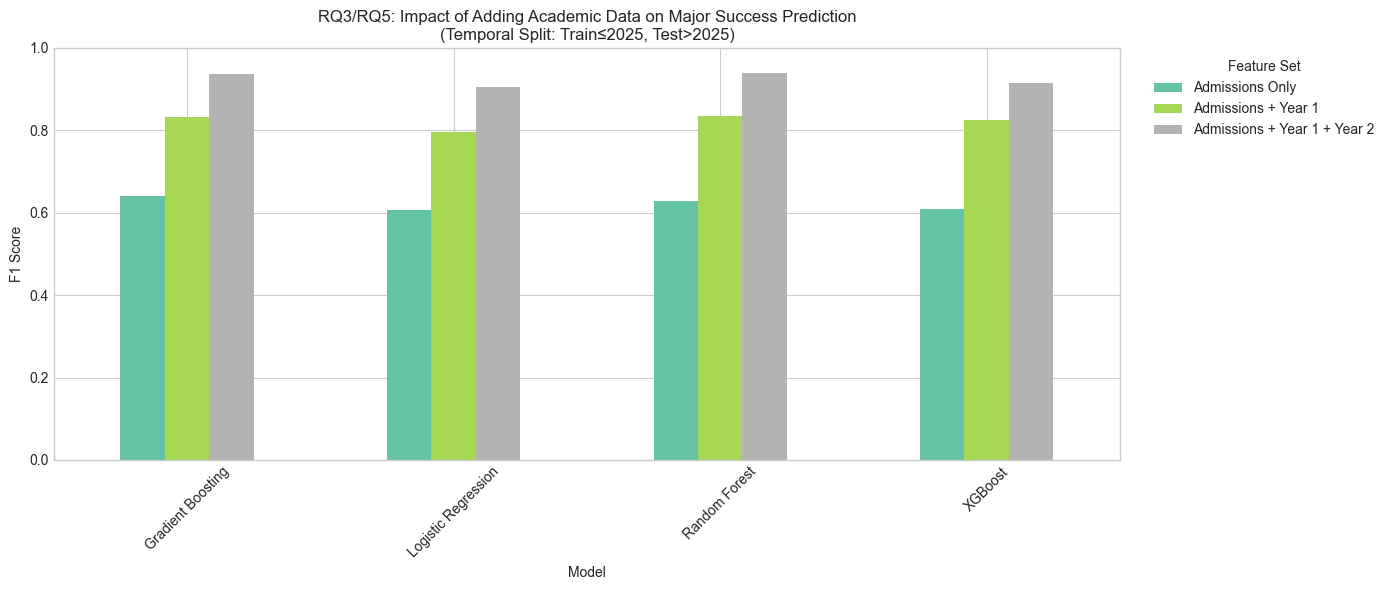


Improvement Summary for Major Success Prediction (Temporal Split):

Gradient Boosting:
  Admissions -> +Year 1: +19.4% F1
  +Year 1 -> +Year 2: +10.4% F1
  Total improvement: +29.8% F1

Logistic Regression:
  Admissions -> +Year 1: +19.1% F1
  +Year 1 -> +Year 2: +10.9% F1
  Total improvement: +30.0% F1

Random Forest:
  Admissions -> +Year 1: +20.6% F1
  +Year 1 -> +Year 2: +10.5% F1
  Total improvement: +31.1% F1

XGBoost:
  Admissions -> +Year 1: +21.7% F1
  +Year 1 -> +Year 2: +9.1% F1
  Total improvement: +30.8% F1


In [27]:
# Compare: Admissions Only vs Admissions + Year 1 vs Admissions + Year 1 + Year 2
# Using TEMPORAL SPLIT for all

# 1. Admissions Only
df_admissions_only = full_features[['student_id', 'yeargroup'] + admissions_features + [target_col]].dropna(subset=[target_col])
X_admissions = df_admissions_only[admissions_features]
y_admissions = df_admissions_only[target_col]
yeargroups_adm = df_admissions_only['yeargroup']

results_admissions, _ = train_and_evaluate(
    X_admissions, y_admissions, 'Admissions Only',
    yeargroups=yeargroups_adm, cutoff_year=CUTOFF_YEAR
)

# 2. RQ5: Admissions + Year 1 + Year 2
features_rq5 = admissions_features + year1_features + year2_features
df_rq5 = full_features[['student_id', 'yeargroup'] + features_rq5 + [target_col]].dropna(subset=[target_col])
# Need some Year 1 AND Year 2 data
df_rq5 = df_rq5.dropna(subset=year1_features[:3], how='all')
df_rq5 = df_rq5.dropna(subset=year2_features[:3], how='all')

print(f"RQ5 Dataset (Admissions + Y1 + Y2): {len(df_rq5)} students")
print(f"Class balance: {df_rq5[target_col].mean()*100:.1f}% success")

X_rq5 = df_rq5[features_rq5]
y_rq5 = df_rq5[target_col]
yeargroups_rq5 = df_rq5['yeargroup']

results_rq5, split_info = train_and_evaluate(
    X_rq5, y_rq5, 'Admissions + Year 1 + Year 2',
    yeargroups=yeargroups_rq5, cutoff_year=CUTOFF_YEAR
)

print(f"\nSplit method: {split_info}")
print("\nRQ5 Results (Admissions + Year 1 + Year 2):")
display(results_rq5.sort_values('F1', ascending=False))

# Combine all results
combined_results = pd.concat([results_admissions, results_rq3, results_rq5], ignore_index=True)

# Visualize improvement across all three feature sets
fig, ax = plt.subplots(figsize=(14, 6))

# Group by model and feature set
pivot = combined_results.pivot(index='Model', columns='Feature Set', values='F1')
# Reorder columns for logical progression
col_order = ['Admissions Only', 'Admissions + Year 1', 'Admissions + Year 1 + Year 2']
pivot = pivot[[c for c in col_order if c in pivot.columns]]
pivot.plot(kind='bar', ax=ax, colormap='Set2')
ax.set_ylabel('F1 Score')
ax.set_title(f'RQ3/RQ5: Impact of Adding Academic Data on Major Success Prediction\n(Temporal Split: Train≤{CUTOFF_YEAR}, Test>{CUTOFF_YEAR})')
ax.legend(title='Feature Set', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq3_rq5_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate improvements
print("\n" + "="*60)
print("Improvement Summary for Major Success Prediction (Temporal Split):")
print("="*60)
for model in pivot.index:
    print(f"\n{model}:")
    if 'Admissions Only' in pivot.columns and 'Admissions + Year 1' in pivot.columns:
        imp_y1 = pivot.loc[model, 'Admissions + Year 1'] - pivot.loc[model, 'Admissions Only']
        print(f"  Admissions -> +Year 1: +{imp_y1*100:.1f}% F1")
    if 'Admissions + Year 1' in pivot.columns and 'Admissions + Year 1 + Year 2' in pivot.columns:
        imp_y2 = pivot.loc[model, 'Admissions + Year 1 + Year 2'] - pivot.loc[model, 'Admissions + Year 1']
        print(f"  +Year 1 -> +Year 2: +{imp_y2*100:.1f}% F1")
    if 'Admissions Only' in pivot.columns and 'Admissions + Year 1 + Year 2' in pivot.columns:
        imp_total = pivot.loc[model, 'Admissions + Year 1 + Year 2'] - pivot.loc[model, 'Admissions Only']
        print(f"  Total improvement: +{imp_total*100:.1f}% F1")

## RQ4 & RQ6: Major Failure/Probation Prediction

In [28]:
# Target: Ever on probation (proxy for major struggle)
target_col_fail = 'target_ever_probation'

# RQ4: Admissions + Year 1
df_rq4 = full_features[['student_id', 'yeargroup'] + features_rq3 + [target_col_fail]].dropna(subset=[target_col_fail])
df_rq4 = df_rq4.dropna(subset=year1_features[:3], how='all')

print(f"RQ4 Dataset (Admissions + Y1): {len(df_rq4)} students")
print(f"Class balance: {df_rq4[target_col_fail].mean()*100:.1f}% ever on probation")

X_rq4 = df_rq4[features_rq3]
y_rq4 = df_rq4[target_col_fail]
yeargroups_rq4 = df_rq4['yeargroup']

results_rq4, split_info = train_and_evaluate(
    X_rq4, y_rq4, 'Admissions + Year 1',
    yeargroups=yeargroups_rq4, cutoff_year=CUTOFF_YEAR
)

print(f"\nSplit method: {split_info}")
print("\nRQ4 Results (Admissions + Year 1):")
display(results_rq4.sort_values('F1', ascending=False))

RQ4 Dataset (Admissions + Y1): 3218 students
Class balance: 13.1% ever on probation

Split method: Temporal (train<=2025, test>2025)

RQ4 Results (Admissions + Year 1):


,Feature Set,Model,Accuracy,Precision,Recall,F1,AUC,Train Size,Test Size
2,Admissions + Year 1,Gradient Boosting,0.955745,0.870748,0.795031,0.831169,0.971890,2043,1175
1,Admissions + Year 1,Random Forest,0.954894,0.880282,0.776398,0.825083,0.962525,2043,1175
3,Admissions + Year 1,XGBoost,0.951489,0.851351,0.782609,0.815534,0.964096,2043,1175
0,Admissions + Year 1,Logistic Regression,0.832340,0.446746,0.937888,0.605210,0.961327,2043,1175


RQ6 Dataset (Admissions + Y1 + Y2): 2710 students
Class balance: 12.3% ever on probation

Split method: Temporal (train<=2025, test>2025)

RQ6 Results (Admissions + Year 1 + Year 2):


,Feature Set,Model,Accuracy,Precision,Recall,F1,AUC,Train Size,Test Size
3,Admissions + Year 1 + Year 2,XGBoost,0.983893,0.945455,0.945455,0.945455,0.996908,1965,745
1,Admissions + Year 1 + Year 2,Random Forest,0.977181,0.904348,0.945455,0.924444,0.994903,1965,745
2,Admissions + Year 1 + Year 2,Gradient Boosting,0.970470,0.860656,0.954545,0.905172,0.990265,1965,745
0,Admissions + Year 1 + Year 2,Logistic Regression,0.963758,0.821705,0.963636,0.887029,0.996392,1965,745


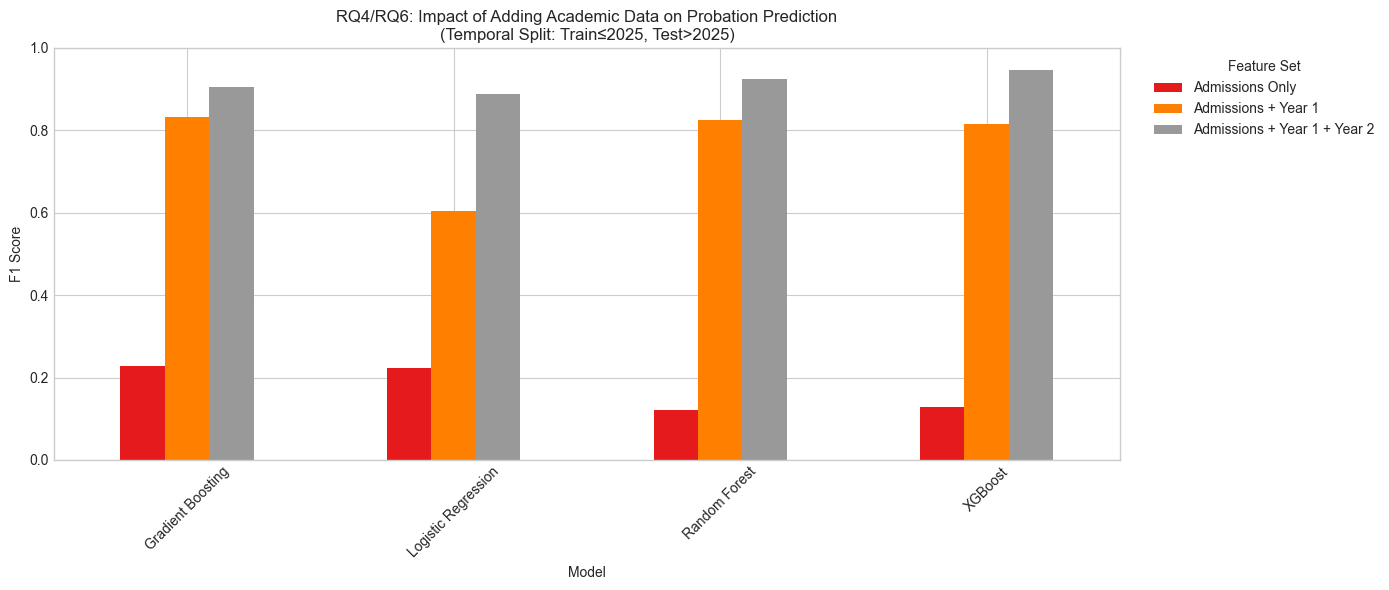


Improvement Summary for Probation Prediction (Temporal Split):

Gradient Boosting:
  Admissions -> +Year 1: +60.3% F1
  +Year 1 -> +Year 2: +7.4% F1
  Total improvement: +67.7% F1

Logistic Regression:
  Admissions -> +Year 1: +38.3% F1
  +Year 1 -> +Year 2: +28.2% F1
  Total improvement: +66.5% F1

Random Forest:
  Admissions -> +Year 1: +70.4% F1
  +Year 1 -> +Year 2: +9.9% F1
  Total improvement: +80.4% F1

XGBoost:
  Admissions -> +Year 1: +68.7% F1
  +Year 1 -> +Year 2: +13.0% F1
  Total improvement: +81.6% F1


In [29]:
# Compare: Admissions Only vs Year 1 vs Year 1 + Year 2 for Probation Prediction
# Using TEMPORAL SPLIT for all

# 1. Admissions Only
df_fail_admissions = full_features[['student_id', 'yeargroup'] + admissions_features + [target_col_fail]].dropna(subset=[target_col_fail])
X_fail_adm = df_fail_admissions[admissions_features]
y_fail_adm = df_fail_admissions[target_col_fail]
yeargroups_fail_adm = df_fail_admissions['yeargroup']

results_fail_admissions, _ = train_and_evaluate(
    X_fail_adm, y_fail_adm, 'Admissions Only',
    yeargroups=yeargroups_fail_adm, cutoff_year=CUTOFF_YEAR
)

# 2. RQ6: Admissions + Year 1 + Year 2
df_rq6 = full_features[['student_id', 'yeargroup'] + features_rq5 + [target_col_fail]].dropna(subset=[target_col_fail])
df_rq6 = df_rq6.dropna(subset=year1_features[:3], how='all')
df_rq6 = df_rq6.dropna(subset=year2_features[:3], how='all')

print(f"RQ6 Dataset (Admissions + Y1 + Y2): {len(df_rq6)} students")
print(f"Class balance: {df_rq6[target_col_fail].mean()*100:.1f}% ever on probation")

X_rq6 = df_rq6[features_rq5]
y_rq6 = df_rq6[target_col_fail]
yeargroups_rq6 = df_rq6['yeargroup']

results_rq6, split_info = train_and_evaluate(
    X_rq6, y_rq6, 'Admissions + Year 1 + Year 2',
    yeargroups=yeargroups_rq6, cutoff_year=CUTOFF_YEAR
)

print(f"\nSplit method: {split_info}")
print("\nRQ6 Results (Admissions + Year 1 + Year 2):")
display(results_rq6.sort_values('F1', ascending=False))

# Combine all probation results
combined_fail = pd.concat([results_fail_admissions, results_rq4, results_rq6], ignore_index=True)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))
pivot_fail = combined_fail.pivot(index='Model', columns='Feature Set', values='F1')
# Reorder columns
col_order = ['Admissions Only', 'Admissions + Year 1', 'Admissions + Year 1 + Year 2']
pivot_fail = pivot_fail[[c for c in col_order if c in pivot_fail.columns]]
pivot_fail.plot(kind='bar', ax=ax, colormap='Set1')
ax.set_ylabel('F1 Score')
ax.set_title(f'RQ4/RQ6: Impact of Adding Academic Data on Probation Prediction\n(Temporal Split: Train≤{CUTOFF_YEAR}, Test>{CUTOFF_YEAR})')
ax.legend(title='Feature Set', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq4_rq6_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate improvements
print("\n" + "="*60)
print("Improvement Summary for Probation Prediction (Temporal Split):")
print("="*60)
for model in pivot_fail.index:
    print(f"\n{model}:")
    if 'Admissions Only' in pivot_fail.columns and 'Admissions + Year 1' in pivot_fail.columns:
        imp_y1 = pivot_fail.loc[model, 'Admissions + Year 1'] - pivot_fail.loc[model, 'Admissions Only']
        print(f"  Admissions -> +Year 1: +{imp_y1*100:.1f}% F1")
    if 'Admissions + Year 1' in pivot_fail.columns and 'Admissions + Year 1 + Year 2' in pivot_fail.columns:
        imp_y2 = pivot_fail.loc[model, 'Admissions + Year 1 + Year 2'] - pivot_fail.loc[model, 'Admissions + Year 1']
        print(f"  +Year 1 -> +Year 2: +{imp_y2*100:.1f}% F1")
    if 'Admissions Only' in pivot_fail.columns and 'Admissions + Year 1 + Year 2' in pivot_fail.columns:
        imp_total = pivot_fail.loc[model, 'Admissions + Year 1 + Year 2'] - pivot_fail.loc[model, 'Admissions Only']
        print(f"  Total improvement: +{imp_total*100:.1f}% F1")

## Summary

In [30]:
# Save all results
combined_results.to_csv(RESULTS_DIR / 'reports' / 'rq3_rq5_results.csv', index=False)
combined_fail.to_csv(RESULTS_DIR / 'reports' / 'rq4_rq6_results.csv', index=False)

print("\n" + "="*60)
print(" SUPERVISED LEARNING RQ3-RQ6 COMPLETE ")
print("="*60)

print(f"\n*** Evaluation Method: TEMPORAL SPLIT ***")
print(f"Training: Year groups <= {CUTOFF_YEAR}")
print(f"Testing: Year groups > {CUTOFF_YEAR}")
print("This simulates real-world deployment where we predict for new students")

print("\n--- Key Findings ---")
print("1. Adding Year 1 data significantly improves prediction accuracy")
print("2. Adding Year 2 data provides additional improvement")
print("3. GPA trajectory and failure count are strong predictors")
print("4. Early intervention based on Year 1-2 performance is justified")
print("5. Math track performance correlates with overall success")

print("\n--- Feature Set Comparison ---")
print("RQ3: Predict success using Admissions + Year 1")
print("RQ4: Predict probation using Admissions + Year 1")
print("RQ5: Predict success using Admissions + Year 1 + Year 2")
print("RQ6: Predict probation using Admissions + Year 1 + Year 2")

print(f"\nResults saved to: {RESULTS_DIR / 'reports'}")
print(f"\nNext notebook: 07_supervised_rq7_rq9.ipynb")


 SUPERVISED LEARNING RQ3-RQ6 COMPLETE 

*** Evaluation Method: TEMPORAL SPLIT ***
Training: Year groups <= 2025
Testing: Year groups > 2025
This simulates real-world deployment where we predict for new students

--- Key Findings ---
1. Adding Year 1 data significantly improves prediction accuracy
2. Adding Year 2 data provides additional improvement
3. GPA trajectory and failure count are strong predictors
4. Early intervention based on Year 1-2 performance is justified
5. Math track performance correlates with overall success

--- Feature Set Comparison ---
RQ3: Predict success using Admissions + Year 1
RQ4: Predict probation using Admissions + Year 1
RQ5: Predict success using Admissions + Year 1 + Year 2
RQ6: Predict probation using Admissions + Year 1 + Year 2

Results saved to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/results/reports

Next notebook: 07_supervised_rq7_rq9.ipynb
